In [45]:
############### Import necessary libraries ####################
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline
from collections import Counter
import sklearn.cluster
import seaborn as sns
from scipy.optimize import minimize
import ot
from functools import reduce
from Matcher import Matcher
from train_parameters import train_parameters
from model_parameters import model_parameters
from sklearn.model_selection import KFold
from utils import computeMAE, computeRMSE
from scipy import sparse
from pyspark.ml.recommendation import ALS as als
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp, NMF, KNNWithMeans, KNNBasic, KNNWithZScore, NormalPredictor, SlopeOne, accuracy
from surprise.model_selection import cross_validate
import warnings
from scipy import sparse
import sklearn.cluster
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")
#############################################################

# Dataset Manipulation

In [46]:
###### Import datasets #######
header = ['userId','movieId','rating','timestamp']
dataset = pd.read_csv("dataset2/ratings.csv", names=header)
dataset

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [47]:
coulmn = ['movieId',' movieTitle','genre'] 
items_dataset = pd.read_csv('dataset2/movies.csv',names=coulmn)
items_dataset


,movieId,movieTitle,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [48]:
###### merge movies and ratings ########
merged_dataset = pd.merge(dataset, items_dataset, how='inner', on='movieId')
merged_dataset

,userId,movieId,rating,timestamp,movieTitle,genre
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [49]:
refined_dataset = merged_dataset.groupby(by=['userId','movieId'], as_index=False).agg({"rating":"mean"})
refined_dataset=refined_dataset[refined_dataset['userId']<51]
refined_dataset

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
7417,50,176101,1.0
7418,50,176371,3.0
7419,50,179073,3.0
7420,50,188301,3.0


In [50]:
num_users = len(refined_dataset['userId'].value_counts())
num_items = len(refined_dataset['movieId'].value_counts())

In [51]:
###### Prepare the calculation of matching matrix #########
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df
Nij= rating_count_df.to_numpy()
N= np.sum(Nij)

In [52]:
rating_count_df1 = pd.DataFrame(refined_dataset.groupby(['userId'])['rating'].sum('rating'))
rating_count_df1.sort_values('userId', ascending=False)
ratingsByUser=rating_count_df1.iloc[:,:1].values

In [53]:
rating_count_df2 = pd.DataFrame(refined_dataset.groupby(['movieId']).size(), columns=['count'])
rating_count_df2.sort_values('count', ascending=False)

,count
movieId,
356,30
318,28
296,28
593,24
2571,23
...,...
3594,1
3584,1
3551,1


Text(0, 0.5, 'number of ratings')

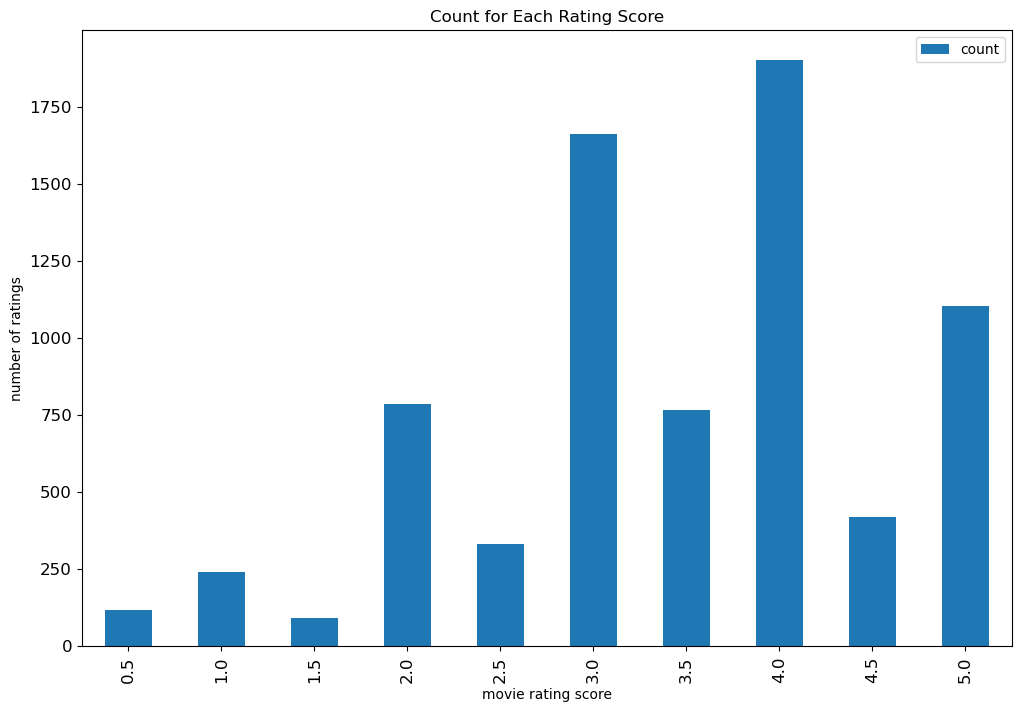

In [54]:
######## Plot the counts of each rating ##########
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [55]:
###### append counts of zero rating #######
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]

In [56]:
rating_count_df = rating_count_df.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
rating_count_df

,count
0.0,137178
0.5,116
1.0,242
1.5,91
2.0,785
2.5,333
3.0,1661
3.5,766
4.0,1904
4.5,420


# Optimal Transport For Movie Lens

In [57]:
####### Pivot and create interaction matrix ##########
user_to_movie_df = refined_dataset.pivot(
    index='userId',
     columns='movieId',
      values='rating').fillna(0)

user_to_movie_df
user_to_movie_df=user_to_movie_df.to_numpy()

In [58]:
user_to_movie_df = user_to_movie_df / user_to_movie_df.max()

In [59]:
n_clusters = 5
user_to_movie_df2 = user_to_movie_df.T
cluster_1 = sklearn.cluster.KMeans(n_clusters)
cluster_2 = sklearn.cluster.KMeans(n_clusters)
cluster_1.fit(user_to_movie_df)
cluster_2.fit(user_to_movie_df2)
U0 = cluster_1.cluster_centers_.T
V0 = cluster_2.cluster_centers_.T
a = cluster_1.labels_.astype(int)
b = cluster_2.labels_.astype(int)

In [60]:
def grouping(user_to_movie_df, n_clusters):    
    Guser_movie = np.empty((n_clusters,n_clusters))
    for i in range (user_to_movie_df.shape[0]):
        k = a[i]
        for j in range (user_to_movie_df.shape[1]):
            l = b[j]
            Guser_movie[k][l] += user_to_movie_df[i][j]  
    Guser_movie /= np.sum(user_to_movie_df)
    return Guser_movie

In [61]:
def get_data(Guser_movie, n_clusters):
    m = n_clusters
    pi_sample = Guser_movie
    rating = []
    for i in range(pi_sample.shape[0]):
        for j in range(pi_sample.shape[1]):
            rating.append([i, j, pi_sample[i][j]])
    X, Y = [], []
    for i in range(pi_sample.shape[0]):
        for j in range(pi_sample.shape[1]):

            X.append(np.append(U0[:,i].reshape(U0.shape[0]), V0[:,j].reshape(V0.shape[0])))
            Y.append(pi_sample[i][j])
        
    return pi_sample, rating, sparse.csr_matrix(np.asarray(X)), np.asarray(Y)

In [62]:
############ Testing RIOT on moviesLens and compare it with other approaches ############
n_fold = 1
#kf = KFold(n_fold)

metric_Random = np.zeros(2)
metric_PMF = np.zeros(2)
metric_SVD = np.zeros(2)
metric_itemKNN = np.zeros(2)
metric_RiOT = np.zeros(2)
metric_FM = np.zeros(2)


#for fold, (train_index, test_index) in enumerate(kf.split(user_to_movie_df)):
train_dataset, test_dataset = user_to_movie_df[:30], user_to_movie_df[31:] 
train_pi_sample, train_rating, train_X, train_Y = get_data(grouping(train_dataset, n_clusters), n_clusters)
test_pi_sample, test_rating, test_X, test_Y = get_data(grouping(test_dataset,n_clusters), n_clusters)
    
labels = ['user', 'item', 'rating']
reader = Reader(rating_scale=(0, 1))
df = pd.DataFrame.from_records(train_rating, columns=labels)
train_surprise = Dataset.load_from_df(df[['user', 'item', 'rating']], reader).build_full_trainset()
df = pd.DataFrame.from_records(test_rating, columns=labels)
test_surprise = Dataset.load_from_df(df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

# Random
algo = NormalPredictor()
algo.fit(train_surprise)
predictions = algo.test(test_surprise)

metric_Random[0] += accuracy.rmse(predictions, verbose=False)
metric_Random[1] += accuracy.mae(predictions, verbose=False)

# PMF
algo = SVD(biased=False)
algo.fit(train_surprise)
predictions = algo.test(test_surprise)

metric_PMF[0] += accuracy.rmse(predictions, verbose=False)
metric_PMF[1] += accuracy.mae(predictions, verbose=False)

# SVD
algo = SVD()
algo.fit(train_surprise)
predictions = algo.test(test_surprise)

metric_SVD[0] += accuracy.rmse(predictions, verbose=False)
metric_SVD[1] += accuracy.mae(predictions, verbose=False)
    
# ItemKNN
algo = KNNWithMeans(k=50, sim_options = {'user_based': False}, verbose=False)
algo.fit(train_surprise)
predictions = algo.test(test_surprise)

metric_itemKNN[0] += accuracy.rmse(predictions, verbose=False)
metric_itemKNN[1] += accuracy.mae(predictions, verbose=False)   

# RiOT
model = Matcher(train_pi_sample, U0, V0, r=5)
lam = 0.01
seed = 3
rng = np.random.RandomState(seed)
G0 = rng.rand(n_clusters, U0.shape[0])
D0 = rng.rand(n_clusters, V0.shape[0])
A0 = np.dot(G0.T, D0)
model_param = model_parameters(A0=A0, gamma=0.2,
                                      const=1,
                                      degree=2,
                                      lam=lam,
                                      lambda_mu=1,
                                      lambda_nu=1,
                                      delta=0.005)
train_param = train_parameters(max_outer_iteration=20,
                                     max_inner_iteration=10,
                                     learning_rate=1)
best_configuration = model.riot(model_param, train_param)
test_r, test_c = test_pi_sample.sum(axis=1), test_pi_sample.sum(axis=0)
pred_pi = ot.rot(best_configuration[0], test_r, test_c, lam)[0]
error_OT = (pred_pi - test_pi_sample).reshape(1, n_clusters*n_clusters)
metric_RiOT += np.array([computeRMSE(error_OT), computeMAE(error_OT)])
    

metric_PMF /= n_fold
metric_SVD /= n_fold
metric_itemKNN /= n_fold
metric_RiOT /= n_fold
        
print(' model   | RMSE   |  MAE')
print(' Random  | {:.5f} |  {:.5f}'.format(metric_Random[0], metric_Random[1]))
print(' PMF     | {:.5f} |  {:.5f}'.format(metric_PMF[0], metric_PMF[1]))
print(' SVD     | {:.5f} |  {:.5f}'.format(metric_SVD[0], metric_SVD[1]))
print(' itemKNN | {:.5f} |  {:.5f}'.format(metric_itemKNN[0], metric_itemKNN[1]))
print(' RiOT    | {:.5f} |  {:.5f}'.format(metric_RiOT[0], metric_RiOT[1]))

[[0.59858819 1.22951282 1.46641208 ... 0.96286718 1.40069983 1.27787486]
 [0.84012413 1.5406986  2.00808548 ... 1.26421343 1.8157725  1.9625647 ]
 [0.23997327 0.81395606 0.73400844 ... 0.46174776 0.95347467 0.87439731]
 ...
 [0.73623674 1.47239431 1.75683997 ... 1.19523944 1.64172688 1.62944973]
 [0.69546135 1.41798592 1.56132047 ... 1.18348078 1.50816746 1.45625377]
 [0.27754838 0.34732713 0.51640814 ... 0.28243915 0.4923893  0.53166487]]
[[0.57831663 1.22805879 1.46630715 ... 0.95947292 1.3983863  1.27115026]
 [0.81998731 1.53925473 2.00798541 ... 1.26083236 1.81346955 1.95590862]
 [0.22004839 0.81498544 0.73411127 ... 0.45910626 0.95204706 0.87205891]
 ...
 [0.73649616 1.47240359 1.75683995 ... 1.19528158 1.64175397 1.62951637]
 [0.695617   1.41799149 1.56132046 ... 1.18350607 1.50818371 1.45629375]
 [0.27772997 0.34733363 0.51640812 ... 0.28246864 0.49240827 0.53171152]]
[[0.55832854 1.22666481 1.46621139 ... 0.95612996 1.39612013 1.26460908]
 [0.80013299 1.53786939 2.00789433 ... 

[[ 0.27165254  1.21019069  1.46531572 ...  0.90857969  1.36473016
   1.17783093]
 [ 0.51456834  1.52132725  2.00701891 ...  1.2100217   1.7798694
   1.86291368]
 [-0.09026524  0.82637513  0.73617638 ...  0.41668216  0.92638413
   0.83302439]
 ...
 [ 0.74056538  1.47254835  1.75683863 ...  1.19594019  1.64218031
   1.6305539 ]
 [ 0.69805853  1.41807834  1.56131966 ...  1.18390123  1.50843952
   1.45691627]
 [ 0.28057843  0.34743496  0.5164072  ...  0.28292967  0.49270671
   0.53243779]]
[[ 0.25594315  1.20985274  1.46533323 ...  0.90601192  1.36320176
   1.17414397]
 [ 0.49888289  1.52097568  2.0070362  ...  1.20745192  1.77833863
   1.85921245]
 [-0.10787796  0.82580696  0.73619208 ...  0.41415458  0.9244193
   0.82877839]
 ...
 [ 0.74078589  1.47255579  1.75683842 ...  1.19597574  1.64220337
   1.63060887]
 [ 0.69819084  1.41808281  1.56131954 ...  1.18392256  1.50845336
   1.45694925]
 [ 0.28073278  0.34744017  0.51640706 ...  0.28295455  0.49272285
   0.53247627]]
 model   | RMSE   